<a href="https://colab.research.google.com/github/guevelel/COMP4449_Image_Classification/blob/main/Traffic_Signs_COMP4449.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP4449 Midterm - Traffic Sign Image Classification
## Edward Guevel


### Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

### Data Import and Preparation

In [1]:
#Import required libraries:
import pandas as pd
import pickle
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_curve
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

mkdir: cannot create directory ‘dataroot’: File exists
--2023-04-19 01:48:47--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip.2’

data_1.zip.2        100%[===================>]  30.59M   156MB/s    in 0.2s    

2023-04-19 01:48:48 (156 MB/s) - ‘dataroot/data_1.zip.2’ saved [32074743/32074743]

--2023-04-19 01:48:48--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to r

In [3]:
# Unzip github files into colab folders:
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

In [4]:
# Load sign names into a dictionary:
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
#signnames
#signnames.values()

In [5]:
# Load training, validation, and testing images:
train = pickle.load( open( dataroot+"train.p", "rb" ) )
val = pickle.load( open( dataroot+"valid.p", "rb" ) )
test = pickle.load( open( dataroot+"test.p", "rb" ) )

print(train.keys())
#type(train)


dict_keys(['coords', 'labels', 'features', 'sizes'])


The image shows a Turn left ahead sign


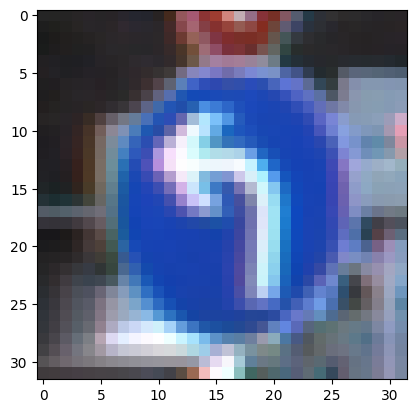

In [6]:
# Preview random image:
inx = 20123
plt.imshow(train['features'][inx])
print("The image shows a {} sign".format(signnames[train['labels'][inx]]))

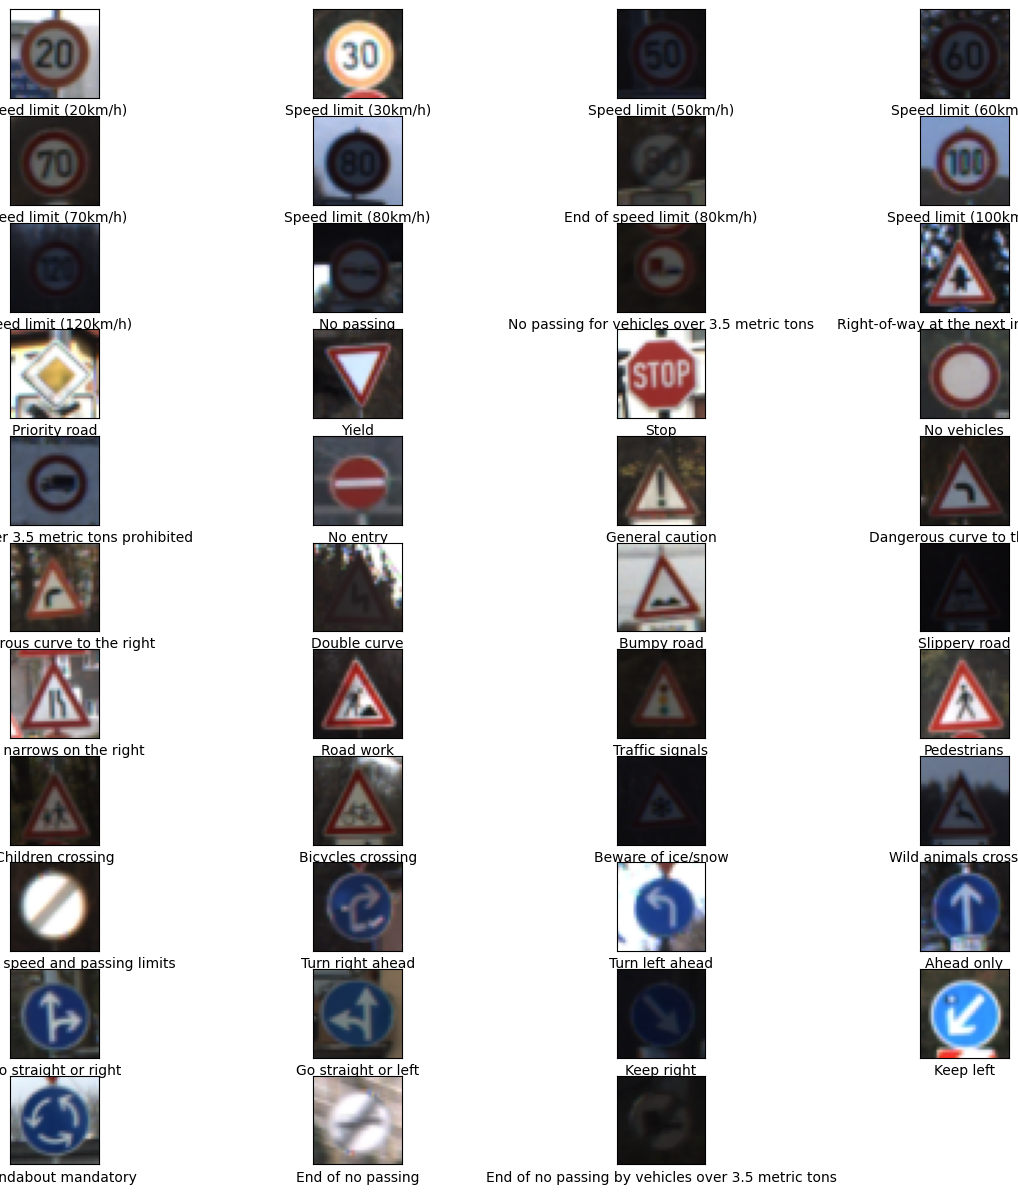

In [7]:
#Visualize all of the different road signs:
plt.figure(figsize=(15,15))
for i in range(43):
  plt.subplot(11,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  titles = np.where(train['labels']==i)
  index = titles[0][50]
  plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(signnames[train['labels'][index]])
plt.show()

Now we will look at the distribution of the entire dataset to see the frequency of each of the 43 distinct labels.

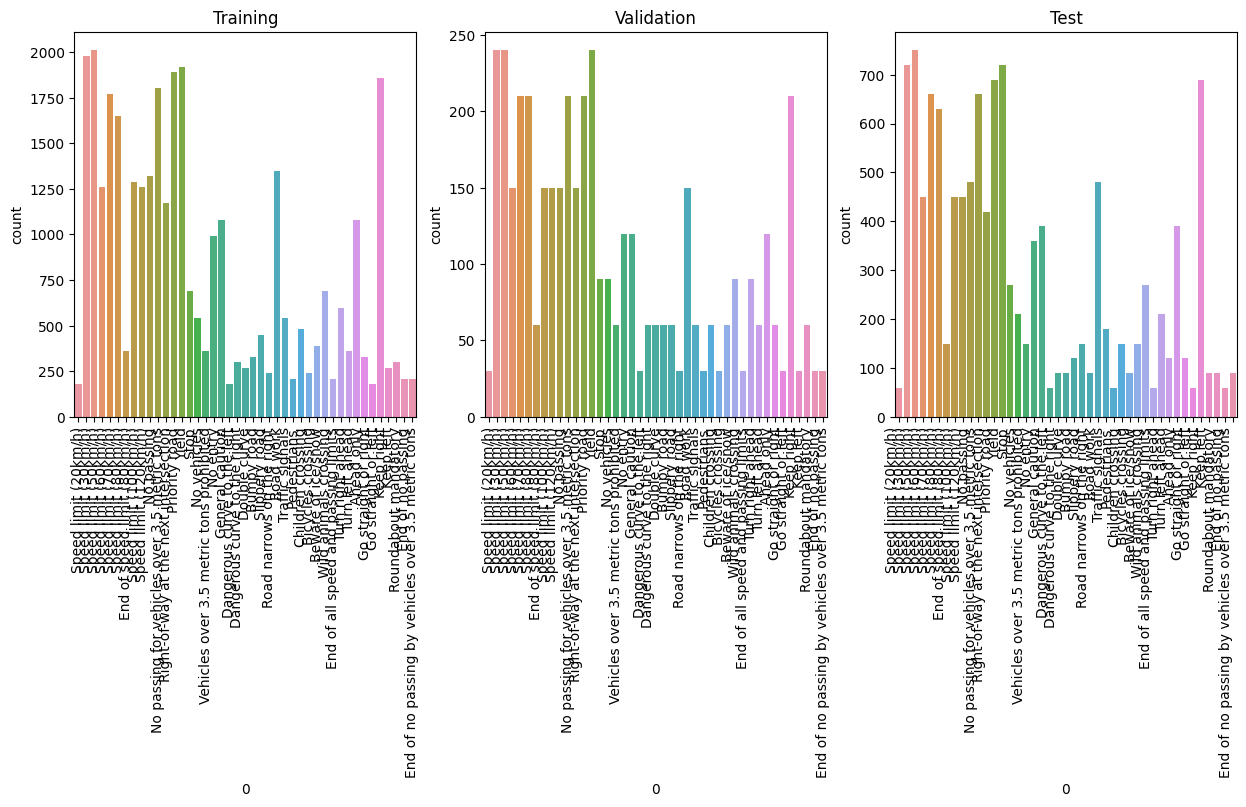

In [8]:
#Plot the distributions of the training, validation, and test data:

#Convert data to DF:
data_train = pd.DataFrame(train['labels'])
data_val = pd.DataFrame(val['labels'])
data_test = pd.DataFrame(test['labels'])

#Generate countplots:
fig, ax =plt.subplots(1,3, figsize=(15,5))
sns.countplot(data_train, x=data_train[0], ax=ax[0])
ax[0].set_title('Training')
ax[0].set_xticklabels(list(signnames.values()))
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

sns.countplot(data_val, x=data_val[0], ax=ax[1])
ax[1].set_title('Validation')
ax[1].set_xticklabels(list(signnames.values()))
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)

sns.countplot(data_test, x=data_test[0], ax=ax[2])
ax[2].set_title('Test')
ax[2].set_xticklabels(list(signnames.values()))
plt.xticks(rotation=90, ha='right')

plt.show()

We can see above that the distribution of labels throught the dataset widely varies across the 43 distinct labels (different signs). This may affect the accuracy and performance of our classifier for the images that have less training samples. 

In [9]:
#look at count distributions
counts = pd.DataFrame(columns = ['index', 'count', 'label'])
for i in range(43):
  titles = np.where(train['labels']==i)
  counts.loc[len(counts.index)] = [i, len(titles[0]), signnames[i]] 
counts.head()


,index,count,label
0,0,180,Speed limit (20km/h)
1,1,1980,Speed limit (30km/h)
2,2,2010,Speed limit (50km/h)
3,3,1260,Speed limit (60km/h)
4,4,1770,Speed limit (70km/h)


### Split the data into Training, Validation, and Test sets
Here we will also normalize all of the image array values to be a float value between 0 and 1 instead of integers between 0 and 225. The image normalization is required for feeding the image arrays into a Convolutional Neural Network.

In [10]:
#Split out data into training, validation, and test sets:
X_train = train['features']
y_train = train['labels']
X_val = val['features']
y_val = val['labels']
X_test = test['features']
y_test = test['labels']

#need to normalize images to feed into NN:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape and one hot encode:
y_train = tf.one_hot(y_train, 43)
y_val = tf.one_hot(y_val, 43)
y_test = tf.one_hot(y_test, 43)

#Check the shape of each data set:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 34799
number of test examples = 12630
X_train shape: (34799, 32, 32, 3)
Y_train shape: (34799, 43)
X_val shape: (4410, 32, 32, 3)
Y_val shape: (4410, 43)
X_test shape: (12630, 32, 32, 3)
Y_test shape: (12630, 43)


The shape of our data is (34799, 32, 32, 3), where 34799 represents the number of images,32*32 represents the image sizes into pixels, and the last 3 represents the RGB value(availability of colored data).

In [11]:
#Convert feature image arrays to tensors:
X_train_tensor = tf.convert_to_tensor(X_train)
X_val_tensor = tf.convert_to_tensor(X_val)
X_test_tensor = tf.convert_to_tensor(X_test)
#print(X_train_tensor)

In [12]:
#Convert data to tensors and move to GPU for faster computing
#setup device agnostoc code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)



cuda


### Model Building

We will start with the basic framework for a LeNet-5 Image Classification Convolutional Neural Network. We will have to adjust the input size to (32, 32, 3) to match the shape of our input images. We will also adjust the softmax output layer to have 43 distinct values to match the number of distinct traffic sign labels in our dataset. 

In [13]:
#Build Neural Network Model: 

#Using an existing LeNet-5 Neural Network framework for image classification as baseline model
#LeNet-5 
model = Sequential()
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid', input_shape=X_train_tensor.shape[1:]))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,))
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(43, activation='softmax'))

#Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [14]:
#Set seed and number of Epochs:
tf.random.set_seed(42)
np.random.seed(42)
eps = 12

#Fit model and track the accuracy and loss:
#history = model.fit(X_train, y_train, batch_size=32, epochs=eps, validation_data=(X_val, y_val))
history = model.fit(X_train_tensor, y_train, batch_size=32, epochs=eps, validation_data=(X_val_tensor, y_val))

Epoch 1/12
1088/1088 [==============================] - 18s 6ms/step - loss: 1.5503 - accuracy: 0.5649 - val_loss: 0.9361 - val_accuracy: 0.7209
Epoch 2/12
1088/1088 [==============================] - 5s 5ms/step - loss: 0.5342 - accuracy: 0.8447 - val_loss: 0.7411 - val_accuracy: 0.7814
Epoch 3/12
1088/1088 [==============================] - 6s 6ms/step - loss: 0.3503 - accuracy: 0.8997 - val_loss: 0.6820 - val_accuracy: 0.8093
Epoch 4/12
1088/1088 [==============================] - 5s 5ms/step - loss: 0.2558 - accuracy: 0.9280 - val_loss: 0.7926 - val_accuracy: 0.7984
Epoch 5/12
1088/1088 [==============================] - 6s 5ms/step - loss: 0.2019 - accuracy: 0.9436 - val_loss: 0.6158 - val_accuracy: 0.8447
Epoch 6/12
1088/1088 [==============================] - 5s 5ms/step - loss: 0.1671 - accuracy: 0.9538 - val_loss: 0.6886 - val_accuracy: 0.8426
Epoch 7/12
1088/1088 [==============================] - 6s 5ms/step - loss: 0.1397 - accuracy: 0.9602 - val_loss: 0.6100 - val_accuracy

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 5)         380       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 5)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 5)         630       
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 5)          0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 125)               0         
                                                                 
 dense (Dense)               (None, 120)               1

We can use the history of the model fitting to graph the accuracy and loss v. epoch. The history.history["loss"] entry is a dictionary with as many values as epochs that the model was trained on. 

       loss  accuracy  val_loss  val_accuracy
0  1.550337  0.564873  0.936072      0.720862
1  0.534188  0.844651  0.741111      0.781406
2  0.350252  0.899681  0.682037      0.809297
3  0.255766  0.927958  0.792599      0.798413
4  0.201950  0.943590  0.615810      0.844671


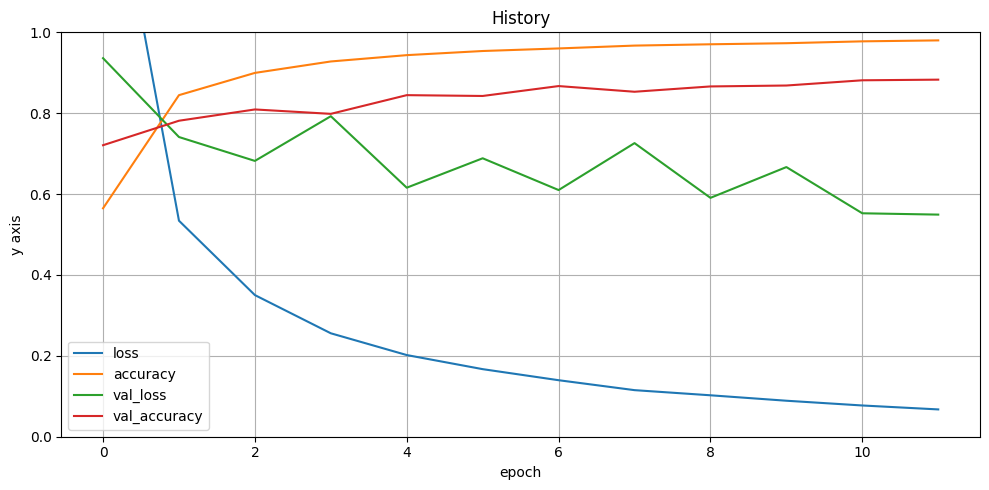

In [16]:
# Plot the train and validation accuracy and loss curves v. epoch:
df=pd.DataFrame(history.history)
print(df.head())

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,1)
ax.grid()
plt.tight_layout()
plt.show()

In [17]:
#Assess accuracy on Test set:
#model.evaluate(X_test, y_test)
tf.random.set_seed(42)
np.random.seed(42)
acc1 = model.evaluate(X_test_tensor, y_test)
print("Baseline Model Loss and Accuracy", acc1)

395/395 [==============================] - 1s 3ms/step - loss: 0.8141 - accuracy: 0.8831
Baseline Model Loss and Accuracy [0.8140508532524109, 0.8831353783607483]


The baseline LeNet-5 CNN model is fairly accurate overrall and is promising for traffic signal image classification. 

In [18]:
#Extract the model predictions on the test set (for confusion matrix building):
tf.random.set_seed(42)
np.random.seed(42)

#pred = model.predict(X_test)
pred = model.predict(X_test_tensor)
#pred

#Convert label matrices to index values for confustion matrix:
y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

#import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

395/395 [==============================] - 1s 2ms/step


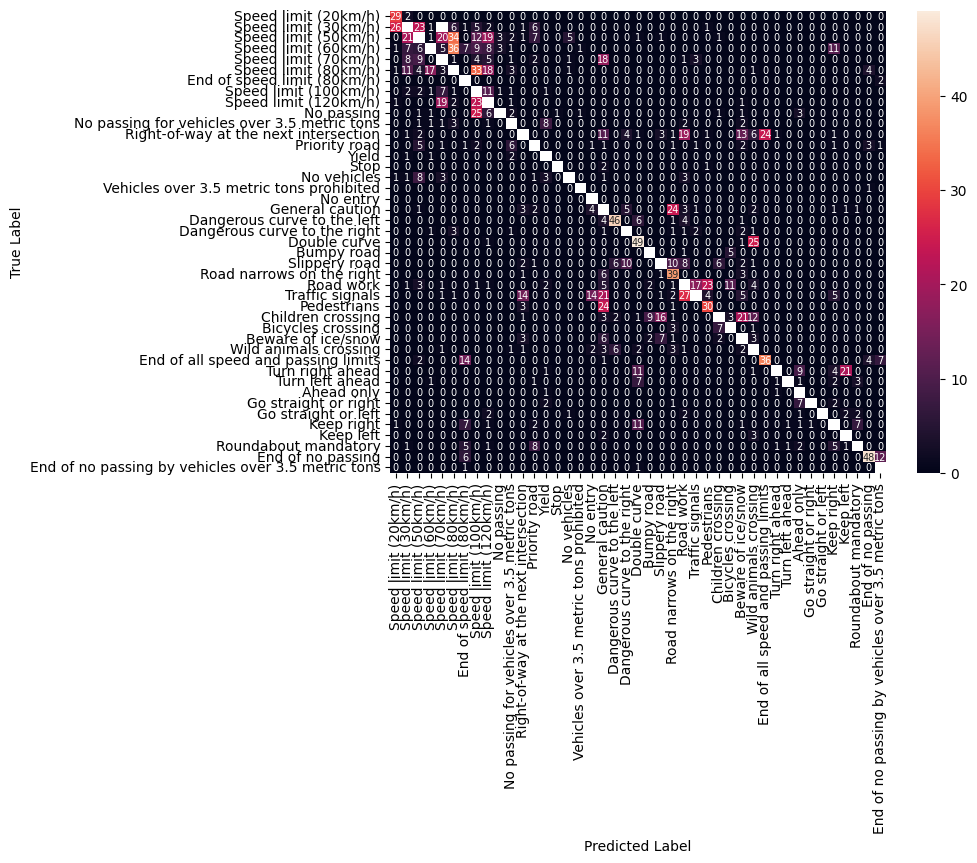

In [19]:
#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(8,6))
corr = confusion_matrix(y_preds, y_act)
names = signnames.values()
#corr/np.sum(corr), fmt='.1%'
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >51)#,
            #cmap="Blues")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

The confusion matrix heatmap shows where our baseline CNN model is misclassifying images. We can see that the upper left corner of the heatmap is showing a lot of misclassifications for the various speed signs. Let's take a look at the speed signs to better understand the issue. 

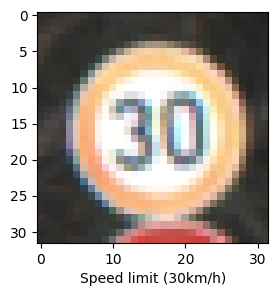

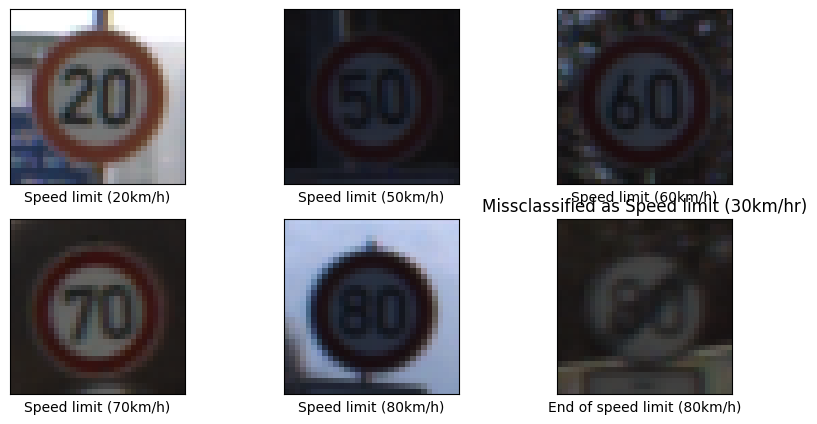

In [20]:
#Plot the misclassified speed sign images:
error_pics = [0,2,3,4,5,6]
actual = [1] #Speed limit (30km/hr) Index

plt.figure(figsize=(3,3))
titles = np.where(train['labels']==actual)
index = titles[0][50]
plt.imshow(train['features'][index], cmap=plt.cm.binary)
plt.xlabel(signnames[train['labels'][index]])
plt.show()

plt.figure(figsize=(10,5))
#for i in range(len(error_pics)):
count = 1
for i in error_pics:
  plt.subplot(2,3,count)
  count+=1
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  titles = np.where(train['labels']==i)
  index = titles[0][50]
  plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(signnames[train['labels'][index]])

plt.title("Missclassified as Speed limit (30km/hr)")
plt.show()

We also noted in the heatmap that the 'Right-of-way at the next intersection' sign was misclassified as a number of other signs. Let's take a look at these images to better understand the issue.

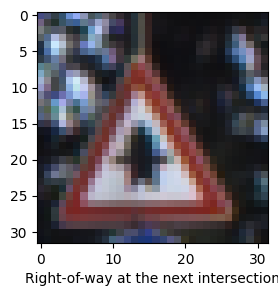

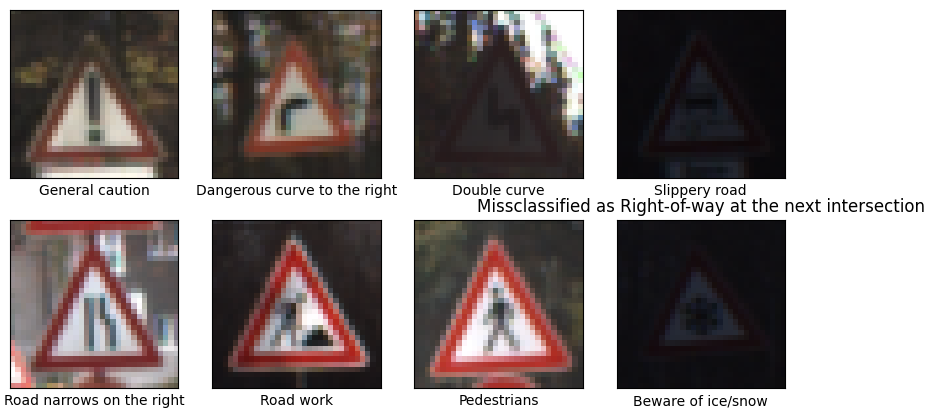

In [21]:
#Error analysis:

#Look at 'Right-of-way at the next intersection' v (general caution and dangerous curve to the left) since those were mis-classified
#more frequently than others

error_pics = [18,20,21,23,24,25, 27, 30]
actual = [11] #Right-of-way at the next intersection Index

plt.figure(figsize=(3,3))
titles = np.where(train['labels']==actual)
index = titles[0][50]
plt.imshow(train['features'][index], cmap=plt.cm.binary)
plt.xlabel(signnames[train['labels'][index]])
plt.show()

plt.figure(figsize=(10,5))
#for i in range(len(error_pics)):
count = 1
for i in error_pics:
  plt.subplot(2,4,count)
  count+=1
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  titles = np.where(train['labels']==i)
  index = titles[0][50]
  plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(signnames[train['labels'][index]])

plt.title("Missclassified as Right-of-way at the next intersection")
plt.show()

#signnames


Since the speed signs have a lot of training data, and the right-of-way signs have little training data, we can't assume that it is soley a data quantity issue. Therefore, let us use data augmentation to not only increase the size of the training data set, but also to rotate, zoom, and shift the images. This augmentation will allow our model to be more robust when taking on new, real-world images. 

In [22]:
#Data Augmentation:
#Rotating, zooming, etc. images
#this makes model more robust to new images it will attempt to classify. Not all images taken are perfect size, shape, etc. 

# set up data generator"
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45,
    #brightness_range=[.9,10.0],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1, #slight zooming
    horizontal_flip=False, #no flipping
    vertical_flip = False)

# Fit the generator using your data:
datagen.fit(X_train)

batch_size = 32
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

#Augment the training data:
augmented = []
for i in range(len(X_train)):
  augmented.append(datagen.random_transform(X_train[i], seed = 42))

In [23]:
#Combine rotated training images with actual training images increase training data size
X_train_enlarged = np.vstack((X_train, augmented))
#X_train_enlarged = torch.stack((augmented,X_train_tensor), dim=0)
print(X_train_enlarged.shape)

y_train_enlarged = np.vstack((y_train, y_train))#, y_train))
print(y_train_enlarged.shape)

(69598, 32, 32, 3)
(69598, 43)


<ipython-input-24-c0993c403271>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aug_counts.append(aug_counts)


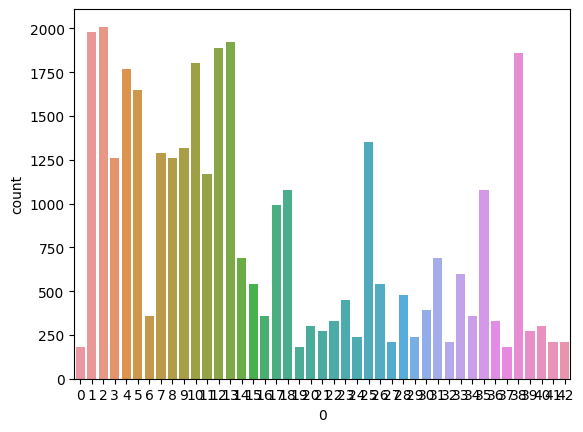

In [24]:
#Look at the updated distribution of the training data after adding augmented values
#Convert data to DF:
aug_counts = pd.DataFrame(train['labels'])
aug_counts.append(aug_counts)

#sns.countplot(aug_counts, x = aug_counts[0])
sns.countplot(aug_counts, x = aug_counts[0])
ax.set_title('Augmented Training Distribution')
ax.set_xticklabels(list(signnames.values()))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

Note that the distribution didn't change, but we doubled the size of our training dataset offering much more values to train on. 

Let's take a look at one example of an augmented image. 

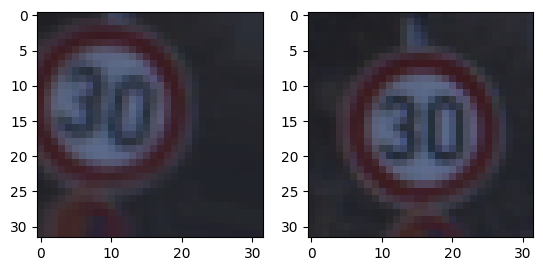

In [25]:
#Show Comparison of Images:
plt.subplot(1,2,1)
z = 4004
plt.imshow(augmented[z])
plt.subplot(1,2,2)
#plt.imshow(X_train[int(z/2)])
plt.imshow(X_train[z])

Now that we have increased the size of our training data with augmented images, we can re-train the baseline CNN model with the new data and asses its performance. 

In [26]:
#Retrain Model with additional data:

#LeNet-5 
model = Sequential()
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid', input_shape=X_train.shape[1:]))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Conv2D(filters=5, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(43, activation='softmax'))

#Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

tf.random.set_seed(42)
np.random.seed(42)
eps = 15

#Fit the model:
#Using the stacked image augmentation:
history = model.fit(X_train_enlarged, y_train_enlarged, batch_size=32, epochs=eps, validation_data=(X_val, y_val))


#If you want to use image augmentation in the model fit:
#history = model.fit(train_generator, batch_size=32, epochs=eps, validation_data=val_generator)


Epoch 1/15
2175/2175 [==============================] - 14s 5ms/step - loss: 1.4159 - accuracy: 0.5883 - val_loss: 1.2325 - val_accuracy: 0.6395
Epoch 2/15
2175/2175 [==============================] - 11s 5ms/step - loss: 0.5577 - accuracy: 0.8297 - val_loss: 0.8520 - val_accuracy: 0.7739
Epoch 3/15
2175/2175 [==============================] - 11s 5ms/step - loss: 0.3503 - accuracy: 0.8944 - val_loss: 1.0085 - val_accuracy: 0.7526
Epoch 4/15
2175/2175 [==============================] - 10s 5ms/step - loss: 0.2478 - accuracy: 0.9275 - val_loss: 0.8167 - val_accuracy: 0.8206
Epoch 5/15
2175/2175 [==============================] - 10s 5ms/step - loss: 0.1906 - accuracy: 0.9434 - val_loss: 0.8537 - val_accuracy: 0.8259
Epoch 6/15
2175/2175 [==============================] - 11s 5ms/step - loss: 0.1519 - accuracy: 0.9545 - val_loss: 0.7361 - val_accuracy: 0.8465
Epoch 7/15
2175/2175 [==============================] - 10s 5ms/step - loss: 0.1281 - accuracy: 0.9619 - val_loss: 0.7656 - val_ac

       loss  accuracy  val_loss  val_accuracy
0  1.415897  0.588336  1.232472      0.639456
1  0.557742  0.829693  0.852011      0.773923
2  0.350293  0.894365  1.008465      0.752608
3  0.247788  0.927455  0.816736      0.820635
4  0.190577  0.943432  0.853733      0.825850


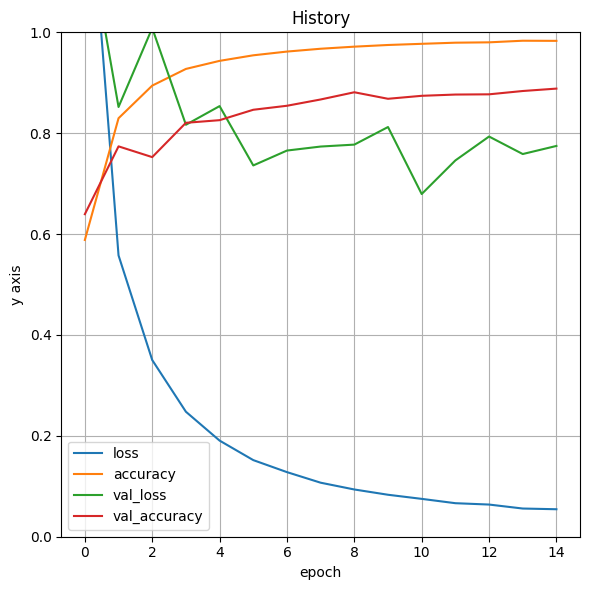

In [27]:
#Plot the loss and accuracy v. Epoch
df=pd.DataFrame(history.history)
print(df.head())

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,1)
ax.grid()
plt.tight_layout()
plt.show()

In [28]:
#Assess accuracy on Test set:
tf.random.set_seed(42)
np.random.seed(42)

#model.evaluate(X_test, y_test)
acc2 = model.evaluate(X_test_tensor, y_test)
print("Enhanced Image-Augmentation Model Loss and Accuracy", acc2)

395/395 [==============================] - 2s 4ms/step - loss: 1.0414 - accuracy: 0.8769
Enhanced Image-Augmentation Model Loss and Accuracy [1.0414336919784546, 0.8768804669380188]


395/395 [==============================] - 1s 2ms/step


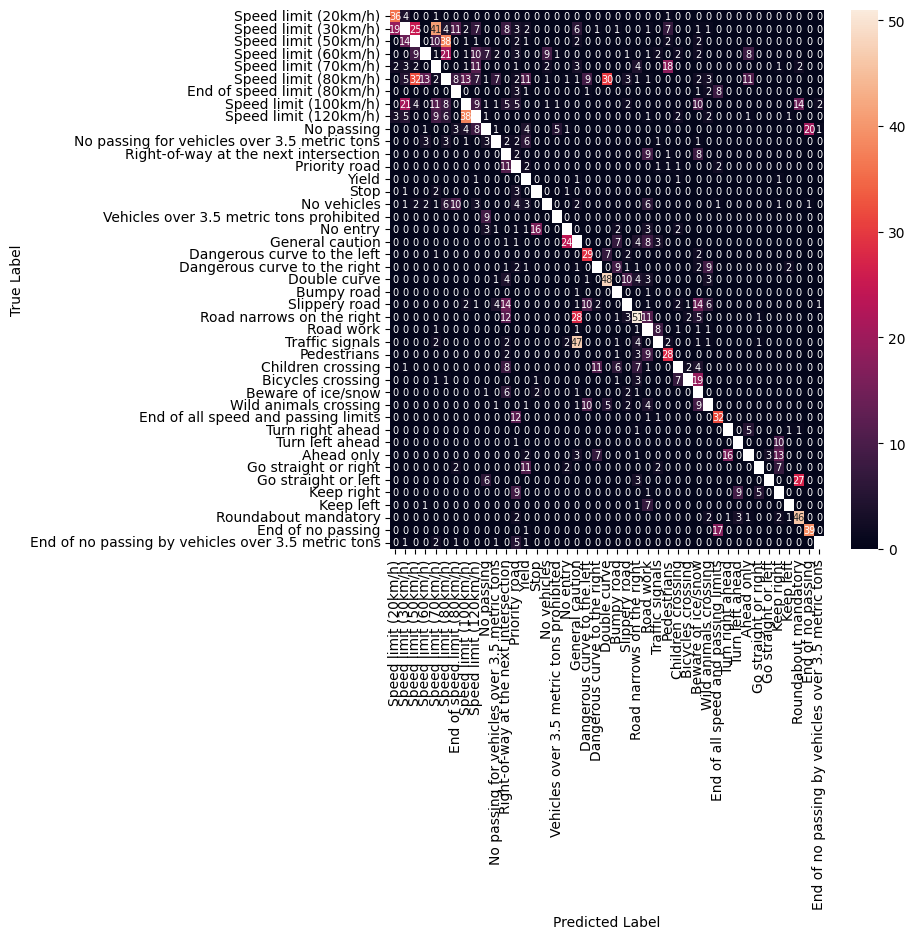

In [29]:
#Extract the model predictions on the test set (for confusion matrix building):
tf.random.set_seed(42)
np.random.seed(42)

pred = model.predict(X_test)
#pred

#Convert label matrices to index values for confustion matrix:
y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

#import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(7,7))
corr = confusion_matrix(y_preds, y_act)
names = signnames.values()
#corr/np.sum(corr), fmt='.1%'
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >51)#,
            #cmap="Blues")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Looking at the performance, accuracy, and confusion matrix heatmap of our model trained with the augmented images, we can see that there is not an increase in overall performance compared to our baseline model. However, our re-trained model is a lot more robust since the training data has a larger variety and number of images. 

Now, let's see if we can improve the overall performance by adding additional layers to our CNN model. I have decided to add additinal Conv2D layers (with increased filter sizes) to help fine tune the classifier. Also, I added dropout layers to reduce overfitting on the training data now that our CNN model has expanded in layers. 

In [30]:
#Improved LeNet-5 

model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='valid', input_shape=X_train.shape[1:]))
model2.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='valid'))
model2.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model2.add(Dropout(rate=0.25)) 
model2.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='valid'))
model2.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='valid'))
model2.add(AveragePooling2D(pool_size=(2,2),strides=2,padding='valid',data_format=None,)) #is this right?
model2.add(Dropout(rate=0.25)) 
model2.add(Flatten())
model2.add(Dense(120, activation='relu'))
model2.add(Dropout(rate=0.25)) 
model2.add(Dense(84, activation='relu'))
model2.add(Dense(43, activation='softmax'))

#Compile the model:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Set random seed and epoch:
tf.random.set_seed(42)
np.random.seed(42)
eps = 12

#Fit the model using the augmented, enlarged data set. (THIS CRASHES DUE TO TOO LARGE OF DATA!)
#history2 = model2.fit(X_train_enlarged, y_train_enlarged, batch_size=32, epochs=eps, validation_data=(X_val, y_val))

history2 = model2.fit(X_train, y_train, batch_size=32, epochs=eps, validation_data=(X_val, y_val))

#Chose not to use image augmentation here
#history2 = model.fit(train_generator, batch_size=32, epochs=eps, validation_data=val_generator)

Epoch 1/12
1088/1088 [==============================] - 18s 11ms/step - loss: 1.5409 - accuracy: 0.5566 - val_loss: 0.3437 - val_accuracy: 0.8825
Epoch 2/12
1088/1088 [==============================] - 7s 6ms/step - loss: 0.3115 - accuracy: 0.9039 - val_loss: 0.1964 - val_accuracy: 0.9401
Epoch 3/12
1088/1088 [==============================] - 6s 6ms/step - loss: 0.1866 - accuracy: 0.9452 - val_loss: 0.0890 - val_accuracy: 0.9782
Epoch 4/12
1088/1088 [==============================] - 7s 7ms/step - loss: 0.1297 - accuracy: 0.9609 - val_loss: 0.0631 - val_accuracy: 0.9807
Epoch 5/12
1088/1088 [==============================] - 11s 10ms/step - loss: 0.0972 - accuracy: 0.9714 - val_loss: 0.0988 - val_accuracy: 0.9726
Epoch 6/12
1088/1088 [==============================] - 8s 7ms/step - loss: 0.0863 - accuracy: 0.9745 - val_loss: 0.0544 - val_accuracy: 0.9857
Epoch 7/12
1088/1088 [==============================] - 8s 7ms/step - loss: 0.0713 - accuracy: 0.9784 - val_loss: 0.1084 - val_accur

In [31]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 average_pooling2d_4 (Averag  (None, 12, 12, 32)       0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 64)          102464    
                                                      

In [32]:
#Assess the accuracy Test set:
tf.random.set_seed(42)
np.random.seed(42)

#model2.evaluate(X_test, y_test)
acc3 = model2.evaluate(X_test_tensor, y_test)
print("Improved LeNet-5 Model Loss and Accuracy", acc3)

395/395 [==============================] - 2s 5ms/step - loss: 0.2069 - accuracy: 0.9544
Improved LeNet-5 Model Loss and Accuracy [0.20686039328575134, 0.9543942809104919]


       loss  accuracy  val_loss  val_accuracy
0  1.540934  0.556625  0.343730      0.882540
1  0.311543  0.903934  0.196403      0.940136
2  0.186633  0.945171  0.088988      0.978231
3  0.129699  0.960918  0.063132      0.980726
4  0.097250  0.971407  0.098833      0.972562


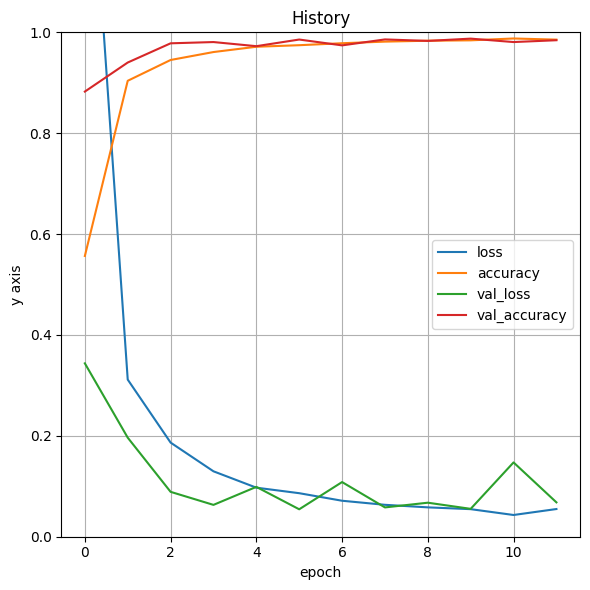

In [33]:
#Plot the loss and accuracy v. Epoch
df=pd.DataFrame(history2.history)
print(df.head())

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(df['loss'], label='loss')
ax.plot(df['accuracy'], label='accuracy')
ax.plot(df['val_loss'], label='val_loss')
ax.plot(df['val_accuracy'], label='val_accuracy')
ax.legend(loc=0)
ax.set_title('History')
ax.set_xlabel('epoch')
ax.set_ylabel('y axis')
ax.set_ylim(0,1)
ax.grid()
plt.tight_layout()
plt.show()

395/395 [==============================] - 1s 2ms/step


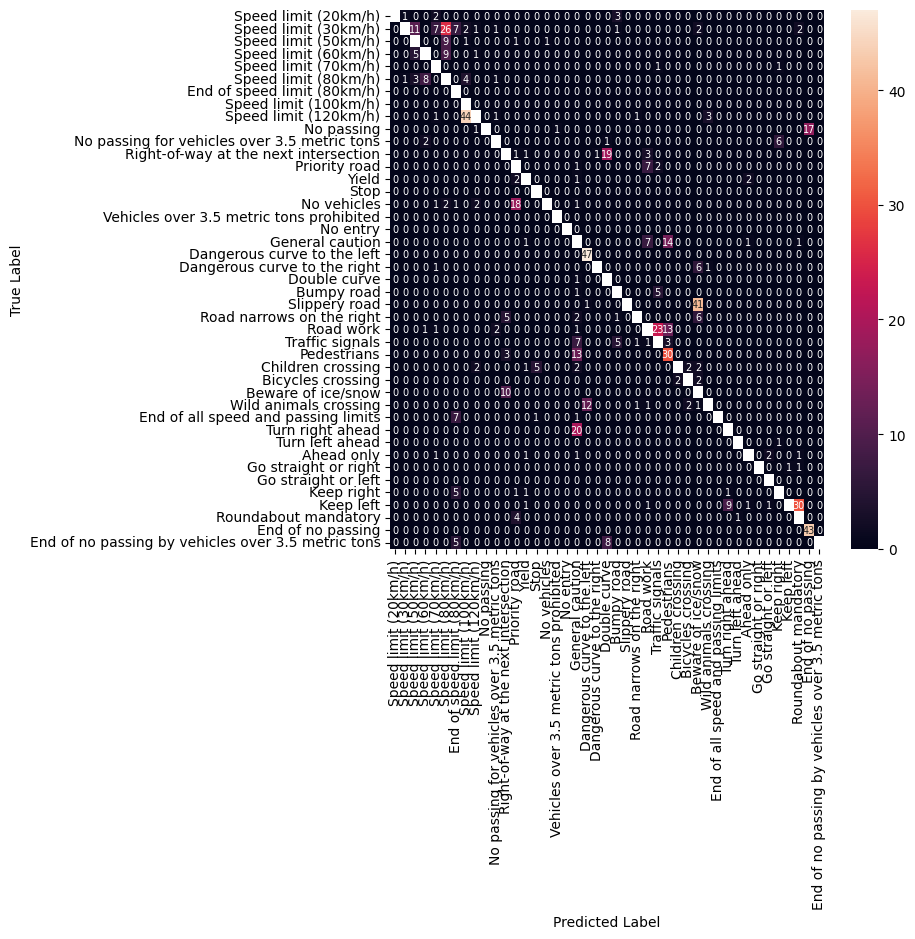

In [34]:
#Extract the model predictions on the test set (for confusion matrix building):
tf.random.set_seed(42)
np.random.seed(42)

pred = model2.predict(X_test)
#pred

#Convert label matrices to index values for confustion matrix:
y_preds = []
for i in range(len(pred)):
  y_preds.append(np.argmax(pred[i]))
#y_preds

y_act = []
for i in range(len(y_test)):
  y_act.append(np.argmax(y_test[i]))
#y_act

#import torch
y_act =torch.Tensor(y_act)
y_preds = torch.Tensor(y_preds)

#Plot heatmap of classification results (masking values >50 to point out misclassifications)
fig, ax = plt.subplots(figsize=(7,7))
corr = confusion_matrix(y_preds, y_act)
names = signnames.values()
#corr/np.sum(corr), fmt='.1%'
sns.heatmap(corr, annot=True,
            xticklabels=names,yticklabels=names, fmt='d',annot_kws={"size": 7},
            mask= corr >51)#,
            #cmap="Blues")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

The added layers and dropout dramatically improved the overall performance of our CNN classifier. We can see in the heatmap above that our model only has a few misclassification issues to resolve. This is a much more robust and accurate model than we initially started with.  

### Conclusion


In conclusion, I have built a fairly accurate CNN Image Classification model for predicting the label associated with the traffic sign images in the dataset. Leveraging the existing LeNet-5 CNN architectrure allowed me to build a baseline CNN model that worked with the traffic sign image dataset. Then, using image-augmentation, I was able to make the baseline model more robust to real-world applications by feeding it more images that were not all the same shape, rotation, and shift. After securing more training data, I expanded the architecture of the CNN to fine tune the added layers, prevent overfitting with dropout, and generate a much more accurate model overall. 